In [1]:
import numpy as np
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns

## The goal

The goal of this notebook is to show how an attacker could infer private information when a publication releases data, especially when someone stands out (like outlier), or a person who differentiate from the rest of the population based on their sensitive information.

Down below we generate 5 individual's height (in meter) where one person (outlier) is extremely high.

data shape: (5, 1)


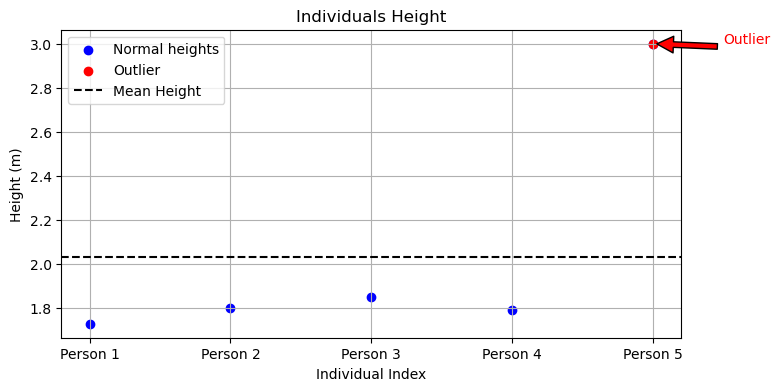

In [2]:
import numpy as np
import matplotlib.pyplot as plt

test_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0])
test_data = test_data.reshape(-1, 1)
print(f"data shape: {test_data.shape}")

plt.figure(figsize=(8, 4))
plt.scatter(range(len(test_data)), test_data, color='blue', label='Normal heights')
outlier_index = np.where(test_data == 3.0)[0][0]
plt.scatter(outlier_index, test_data[outlier_index], color='red', label='Outlier')
plt.annotate('Outlier', 
             xy=(outlier_index, test_data[outlier_index]), 
             xytext=(outlier_index+0.5, test_data[outlier_index]),
             arrowprops=dict(facecolor='red', shrink=0.05),
             color='red')

plt.axhline(np.mean(test_data), color='black', linestyle='--', label='Mean Height')
plt.title("Individuals Height")
plt.xlabel("Individual Index")
indices = np.arange(len(test_data))
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.ylabel("Height (m)")
plt.legend()
plt.grid(True)
plt.show()

## Influence Functions and Privacy

The statistic of the data changes when a single point is added or removed from the population. Here we show how statistical summaries can leak information through Influence Function (IF) which measures how much a statistic changes.

### Leave-One-Out (LOO) Estimation
If removing one record, often via leave-one-out (LOO), changes the result significantly, that point has high influence. In the context of privacy, attackers can exploit high influence to infer sensitive attributes from published results.

**How LOO works?**

LOO works by removing one data point at a time from the dataset, recalculating the statistic, and comparing it to the original. The change shows how much that point influences the result.

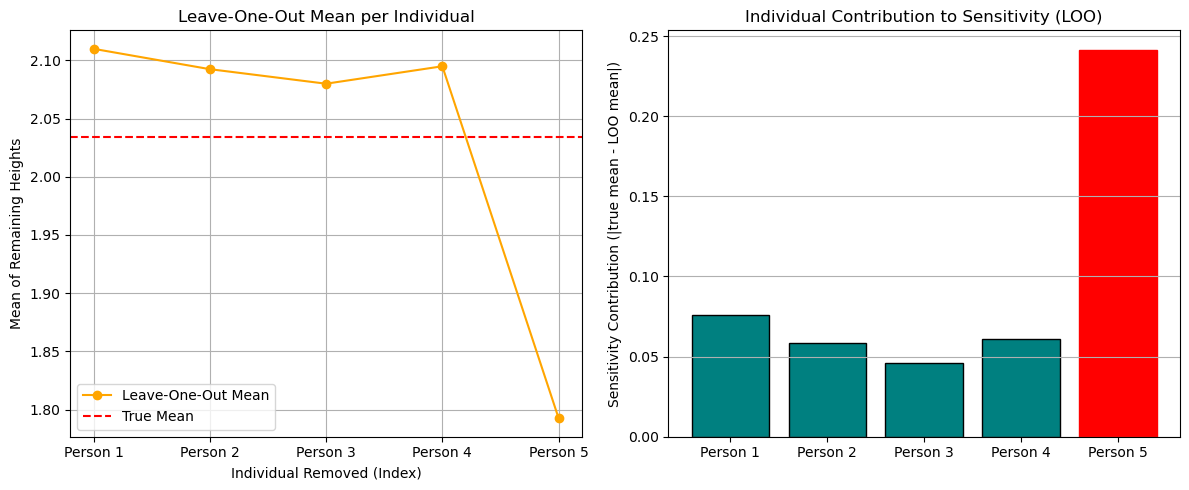

In [3]:
aprx_est = np.array([np.mean(np.delete(test_data, i)) for i in range(test_data.shape[0])]).reshape(-1, 1)

n = len(test_data)
true_mean = np.mean(test_data)
loo_means = np.array([np.mean(np.delete(test_data, i)) for i in range(n)])

sensitivity = np.abs(true_mean - loo_means)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(len(aprx_est)), aprx_est, marker='o', color='orange', label='Leave-One-Out Mean')
axes[0].axhline(true_mean, color='red', linestyle='--', label='True Mean')
axes[0].set_title("Leave-One-Out Mean per Individual")
axes[0].set_xlabel("Individual Removed (Index)")
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f"Person {i + 1}" for i in range(n)])
axes[0].set_ylabel("Mean of Remaining Heights")
axes[0].legend()
axes[0].grid(True)

bars = axes[1].bar(range(n), sensitivity, color='teal', edgecolor='black')
bars[-1].set_color('red')  
axes[1].set_xticks(range(n))
axes[1].set_xticklabels([f"Person {i + 1}" for i in range(n)])
axes[1].set_ylabel("Sensitivity Contribution (|true mean - LOO mean|)")
axes[1].set_title("Individual Contribution to Sensitivity (LOO)")
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


## Observation:

One individual (with height 3.0 meters) causes a significant drop in the mean when removed, clearly indicating it's an outlier or someone that differs from others in height. An attacker could identify this participant due to their disproportionate influence on the aggregate statistic.

## Sensitive Information Inference

Here we show how LOO means can be used to reconstruct the original values by solving a linear equations.
This is the height of individuals which attacker does not have access.

$$ [1.73, 1.8, 1.85, 1.79, 3.0] $$

Assuming a study has published their result in form of LOO mean

$$ [2.11, 2.093, 2.08, 2.095 , 1.79]$$ 

An attacker can compute the sum of the remaining 4 values for each LOO mean:

$$
\begin{aligned}
x_{1} + x_{2} + x_{3} + x_{4} &= 4 \cdot 2.11 = 8.44 \\
x_{1} + x_{2} + x_{3} + x_{4} &= 4 \cdot 2.09 = 8.37 \\
x_{1} + x_{2} + x_{3} + x_{4} &= 4 \cdot 2.08 = 8.32 \\
x_{1} + x_{2} + x_{3} + x_{4} &= 4 \cdot 2.09 = 8.38 \\
x_{1} + x_{2} + x_{3} + x_{4} &= 4 \cdot 1.79 = 7.16 \\
\end{aligned}
$$

This gives the attacker 5 equations in 5 unknowns $x_{1} + x_{2} + x_{3} + x_{4}$:
$$
\begin{aligned}
A \cdot x = b
\end{aligned}
$$

Where:
Matrix A (LOO mask):

$$
\begin{bmatrix}
0 & 1 & 1 & 1 & 1 \\
1 & 0 & 1 & 1 & 1 \\
1 & 1 & 0 & 1 & 1 \\
1 & 1 & 1 & 0 & 1 \\
1 & 1 & 1 & 1 & 0 \\
\end{bmatrix}
$$

Vector b (LOO sums):
$$
\begin{bmatrix}
8.44 \\
8.37 \\
8.32 \\
8.38 \\
7.16 \\
\end{bmatrix}
$$

### Solve for the equation
#### Step 1: Sum All Equations
Add all 5 equations:
$$
\begin{aligned}
&(x_2 + x_3 + x_4 + x_5) + (x_1 + x_3 + x_4 + x_5) \\
&+ (x_1 + x_2 + x_4 + x_5) + (x_1 + x_2 + x_3 + x_5) \\
&+ (x_1 + x_2 + x_3 + x_4) = 8.44 + 8.37 + 8.32 + 8.38 + 7.16
\end{aligned}
$$

Simplify the left-hand side:
$$
4x_1 + 4x_2 + 4x_3 + 4x_4 + 4x_5 = 40.67
$$

Divide by 4:
$$
x_1 + x_2 + x_3 + x_4 + x_5 = 10.1675 \quad \text{(Total sum)}
$$

#### Step 2: Solve for Each \( x_i \)
$$
\begin{aligned}
x_1 &= 10.1675 - 8.44 = 1.7275 \\
x_2 &= 10.1675 - 8.37 = 1.7975 \\
x_3 &= 10.1675 - 8.32 = 1.8475 \\
x_4 &= 10.1675 - 8.38 = 1.7875 \\
x_5 &= 10.1675 - 7.16 = 3.0075 \\
\end{aligned}
$$

#### Final Solution
$$
x = 
\begin{bmatrix}
1.7275 \\
1.7975 \\
1.8475 \\
1.7875 \\
3.0075 \\
\end{bmatrix} \approx 
\begin{bmatrix}
1.73 \\
1.8 \\
1.85 \\
1.79 \\
3.0 \\
\end{bmatrix}
$$



Original data: [1.73 1.8  1.85 1.79 3.  ]
Reconstructed: [1.73 1.8  1.85 1.79 3.  ]


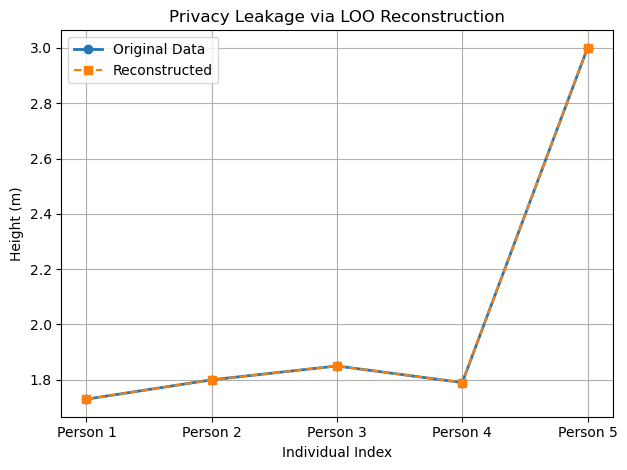

In [25]:
print("Original data:", test_data.flatten())
print("Reconstructed:", np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * loo_means))


indices = np.arange(len(test_data))

plt.plot(indices, test_data, marker='o', label='Original Data', linewidth=2)
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * loo_means), marker='s', label='Reconstructed', linestyle='--')

plt.title("Privacy Leakage via LOO Reconstruction")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

This example shows how publishing LOO statistc can unintentionally leak individual level data. By solving a simple system of linear equations, an attacker can reconstruct the original values with high accuracy. The presence of an outlier (the 3.0m height) makes the reconstruction even more precise due to its large influence on the mean. This highlights how even aggregated statistics, if not carefully protected, can compromise privacy. Care must be taken when releasing summary data to avoid enabling such inference attacks.